In [56]:
# Import required libraries for essay evaluation workflow
from langchain_cohere import ChatCohere
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
from pydantic import Field, BaseModel
from dotenv import load_dotenv
import os
import operator

In [57]:
# Load environment variables and initialize Cohere LLM
load_dotenv()
cohere_api_key = os.getenv("COHERE_API_KEY")
llm = ChatCohere(model="command-a-03-2025")

In [58]:
# Define the schema for structured LLM output (feedback and score)
class EvaluationSchema(BaseModel):
    # 'feedback' as a required string with a clear description for the LLM
    feedback: str = Field(
        description="A detailed analysis of the work, highlighting strengths and weaknesses."
    )
    
    # 'score' as a required integer (range constraints removed for compatibility)
    score: int = Field(
        description="A numerical score out of 10.",
    )

In [59]:
# Wrap the LLM to return structured output using the defined schema
structured_llm = llm.with_structured_output(EvaluationSchema)

In [60]:
# --- Example essay text to be evaluated ---
example_txt = """Many schools around the world require students to wear uniforms, while others allow free choice of clothing. In my opinion, school uniforms have both advantages and disadvantages, but overall they are more beneficial than harmful.
One major advantage of school uniforms is that they promote equality among students. When everyone wears the same clothes, differences in family income are less visible. This can reduce bullying and pressure on students to wear expensive or fashionable clothing. As a result, students may feel more comfortable and focused on their studies rather than on their appearance.
Another benefit is that uniforms can improve discipline and school identity. Wearing a uniform helps students feel that they belong to a community and represent their school. This sense of belonging may encourage better behavior, both inside and outside the classroom. In addition, uniforms make it easier for teachers to identify students, which can improve safety during school trips or events.
However, there are also some disadvantages to school uniforms. One common argument is that uniforms limit students' freedom of expression. Clothing is often a way for young people to show their personality, and wearing the same outfit every day can feel restrictive. Moreover, buying uniforms can still be expensive for some families, especially if schools require specific suppliers.
In conclusion, although school uniforms may reduce personal expression and create some financial burden, their advantages outweigh the disadvantages. By promoting equality, discipline, and a strong school identity, uniforms can create a better learning environment for students. For these reasons, schools should consider maintaining or introducing uniform policies."""

In [61]:
# --- Create a prompt for the LLM to evaluate the essay ---
prompt = f"""
    Analyze the following essay: {example_txt}
    Please evaluate the following essay and give it a score out of 10. Provide brief feedback on content, organization, grammar, and vocabulary, and suggest one or two ways to improve it.
    """

In [62]:
# Get structured feedback and score for the essay using the LLM
structured_result = structured_llm.invoke(prompt)
structured_result

EvaluationSchema(feedback="The essay presents a well-balanced argument for and against school uniforms, demonstrating a clear understanding of the topic. The content is structured logically, with a clear introduction, body paragraphs discussing advantages and disadvantages, and a concise conclusion. The grammar is generally strong, with only minor errors that do not impede comprehension. Vocabulary is appropriate and varied, effectively conveying the writer's points. To improve, the essay could include more specific examples or evidence to support the claims, such as studies or real-life scenarios. Additionally, the conclusion could be strengthened by summarizing the main points more explicitly before restating the thesis.", score=8)

In [63]:
# --- Display only the feedback from the structured result ---
structured_result.feedback

"The essay presents a well-balanced argument for and against school uniforms, demonstrating a clear understanding of the topic. The content is structured logically, with a clear introduction, body paragraphs discussing advantages and disadvantages, and a concise conclusion. The grammar is generally strong, with only minor errors that do not impede comprehension. Vocabulary is appropriate and varied, effectively conveying the writer's points. To improve, the essay could include more specific examples or evidence to support the claims, such as studies or real-life scenarios. Additionally, the conclusion could be strengthened by summarizing the main points more explicitly before restating the thesis."

In [64]:
# --- Print only the score from the structured result ---
print(structured_result.score)

8


In [65]:
# --- Convert structured result to dictionary and print ---
structured_result_dict = structured_result.model_dump() 
print(structured_result_dict)

{'feedback': "The essay presents a well-balanced argument for and against school uniforms, demonstrating a clear understanding of the topic. The content is structured logically, with a clear introduction, body paragraphs discussing advantages and disadvantages, and a concise conclusion. The grammar is generally strong, with only minor errors that do not impede comprehension. Vocabulary is appropriate and varied, effectively conveying the writer's points. To improve, the essay could include more specific examples or evidence to support the claims, such as studies or real-life scenarios. Additionally, the conclusion could be strengthened by summarizing the main points more explicitly before restating the thesis.", 'score': 8}


In [66]:
# Define the state with a Reducer for the scores
class EssayEvaluate(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_score: Annotated[list[int], operator.add] # Merges results from parallel nodes
    average_score: float

In [ ]:
# In a parallel LangGraph workflow, multiple nodes run at the exact same time. If two nodes try to update the same key
# (like individual_score) simultaneously, one will overwrite the other and you will lose data.
# The Annotated[List[int], operator.add] code is the "LangGraph way" of saying:
# "Don't overwrite this list; instead, append whatever new data comes in to the existing list."

In [67]:
# --- Function: Evaluate language use, grammar, sentence structure, and vocabulary ---
def language_feedback(state: EssayEvaluate):
    prompt = f"""
    Evaluate the following essay for language use, grammar, sentence structure, and vocabulary:
    {state['essay']}

    Provide:
    - Brief feedback on grammar, sentence structure, and vocabulary.
    - Point out specific examples of errors or awkward phrasing (quote short excerpts if needed).
    - Recommend one or two concrete ways to improve the language/vocabulary.
    - Give a numerical score out of 10.
    """
    result = structured_llm.invoke(prompt)
    return {"language_feedback": result.feedback, "individual_score": [result.score]}

In [68]:
# --- Function: Evaluate depth of analysis and critical thinking ---
def analysis_feedback(state: EssayEvaluate):
    prompt = f"""
    Evaluate the following essay for depth of analysis and critical thinking:
    {state['essay']}

    Provide:
    - Brief feedback on how well the essay analyzes the topic, considers multiple perspectives, and supports arguments with evidence or reasoning.
    - Point out specific examples of strong or weak analysis (quote short excerpts if needed).
    - Recommend one or two concrete ways to deepen the analysis or strengthen the argumentation.
    - Give a numerical score out of 10.
    """
    result = structured_llm.invoke(prompt)
    return {"analysis_feedback": result.feedback, "individual_score": [result.score]}

In [69]:
# --- Function: Evaluate clarity and understanding ---
def clarity_feedback(state: EssayEvaluate):
    prompt = f"""
    Evaluate the following essay for clarity and understanding:
    {state['essay']}

    Provide:
    - Brief feedback on how well the essay conveys the main points of the argument.
    - Point out specific examples of unclear or ambiguous language (quote short excerpts if needed).
    - Recommend one or two concrete ways to improve the clarity or understanding.
    - Give a numerical score out of 10.
    """
    result = structured_llm.invoke(prompt)
    return {"clarity_feedback": result.feedback, "individual_score": [result.score]}

In [70]:
# --- Aggregator: Combine feedback and calculate average score ---
def final_aggregator(state: EssayEvaluate):
    average_score = sum(state['individual_score']) / len(state['individual_score'])
    overall_feedback = f"""
    After analyzing the essay, the following feedback was provided:\n
    Feedback for language/grammar:\n
    {state['language_feedback']}\n
    language score: {state['individual_score'][0]}\n
    Feedback for analysis:\n
    {state['analysis_feedback']}\n
    analysis score: {state['individual_score'][1]}\n
    Feedback for clarity:\n
    {state['clarity_feedback']}\n
    clarity score: {state['individual_score'][2]}\n
    and the average score is {average_score}
    """
    return {
        "overall_feedback": overall_feedback,
        "average_score": average_score
    }

In [71]:
# Build a state graph for the essay evaluation workflow.
# Each node runs a specific evaluator and their scores are merged by the Reducer on 'individual_score'.
graph = StateGraph(EssayEvaluate)

# Add nodes: three evaluators and a final aggregator
graph.add_node("language_feedback", language_feedback)
graph.add_node("analysis_feedback", analysis_feedback)
graph.add_node("clarity_feedback", clarity_feedback)
graph.add_node("final_aggregator", final_aggregator)

# Start the three evaluators in parallel
graph.add_edge(START, "language_feedback")
graph.add_edge(START, "analysis_feedback")
graph.add_edge(START, "clarity_feedback")

# After evaluators complete, send their outputs to the aggregator
graph.add_edge("language_feedback", "final_aggregator")
graph.add_edge("analysis_feedback", "final_aggregator")
graph.add_edge("clarity_feedback", "final_aggregator")

# Final aggregator leads to the end state
graph.add_edge("final_aggregator", END)

# Compile the graph into an executable workflow
workflow = graph.compile()

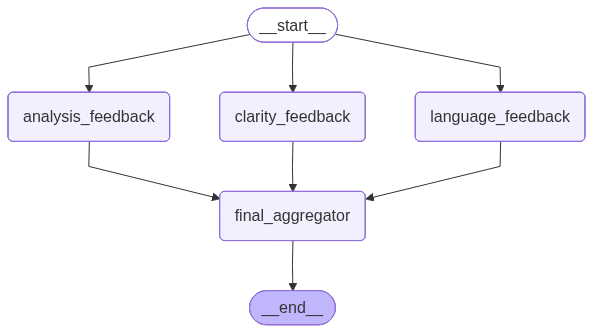

In [72]:
graph.compile()

In [ ]:
# Initialize the state with the example essay and run the evaluation workflow
initial_state = {
    "essay": example_txt
}

result = workflow.invoke(initial_state)

In [79]:
# Print the Result
print(result)


{'essay': "Many schools around the world require students to wear uniforms, while others allow free choice of clothing. In my opinion, school uniforms have both advantages and disadvantages, but overall they are more beneficial than harmful.\nOne major advantage of school uniforms is that they promote equality among students. When everyone wears the same clothes, differences in family income are less visible. This can reduce bullying and pressure on students to wear expensive or fashionable clothing. As a result, students may feel more comfortable and focused on their studies rather than on their appearance.\nAnother benefit is that uniforms can improve discipline and school identity. Wearing a uniform helps students feel that they belong to a community and represent their school. This sense of belonging may encourage better behavior, both inside and outside the classroom. In addition, uniforms make it easier for teachers to identify students, which can improve safety during school tri

In [75]:
# Print the average score
print(result["average_score"])

8.0


In [76]:
# Print the analysis feedback
print(result['analysis_feedback'])

The essay provides a balanced analysis of the topic, considering both the advantages and disadvantages of school uniforms. It effectively highlights the benefits of promoting equality, discipline, and school identity, as well as acknowledging the drawbacks related to limited personal expression and financial burden. The argument is supported by logical reasoning, such as the statement, 'When everyone wears the same clothes, differences in family income are less visible,' which directly links uniforms to reduced socioeconomic disparities. However, the analysis could be deepened by incorporating specific examples or empirical evidence to support claims, such as studies on bullying reduction or student behavior improvements. Additionally, the essay could explore counterarguments more thoroughly, such as addressing whether the restriction on personal expression has long-term impacts on students' self-identity. Including these elements would strengthen the overall argument and provide a mor

In [77]:
# Print the clarity feedback
print(result['clarity_feedback'])

The essay effectively conveys the main points of the argument, presenting a balanced view of the advantages and disadvantages of school uniforms. It clearly outlines the benefits, such as promoting equality and improving discipline, while also acknowledging drawbacks like limited personal expression and financial burden. The structure is logical, with a clear introduction, body, and conclusion. However, some language could be more precise. For example, the phrase 'This sense of belonging may encourage better behavior, both inside and outside the classroom' is somewhat vague. It would be stronger if specific examples or evidence were provided to illustrate how uniforms encourage better behavior. Additionally, the sentence 'buying uniforms can still be expensive for some families, especially if schools require specific suppliers' could be expanded to explain why specific suppliers increase costs. To improve clarity, the author could include more concrete examples or data to support claim

In [ ]:
# Print the overall feedback
print(result["overall_feedback"])
# Comment: Overall feedback (includes language, analysis, clarity)


    After analyzing the essay, the following feedback was provided:

    Feedback for language/grammar:

    The essay is well-structured and demonstrates a good command of language, grammar, and vocabulary. The ideas are presented clearly and logically, with a balanced discussion of both advantages and disadvantages of school uniforms. The sentence structure is mostly varied and effective, though some sentences could be more concise. For example, the phrase 'both inside and outside the classroom' could be simplified to 'both in and out of the classroom' for brevity. Additionally, the use of 'may' in 'This sense of belonging may encourage better behavior' could be replaced with 'can' for a more assertive tone. Vocabulary is appropriate and varied, though some repetition, such as 'uniforms' and 'school,' could be reduced by using synonyms like 'attire' or 'institution' in places. Overall, the essay is persuasive and well-argued.

    language score: 8

    Feedback for analysis:

    T